In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import torch
from torch.nn import Sequential, Linear, ReLU, CrossEntropyLoss
torch.__version__

'2.3.0'

In [10]:
# Check if MPS (Apple GPU support) is available and use it; otherwise, use CPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [11]:
df = pd.read_parquet("polyOne_aa.parquet")
df

,smiles,Egc,Egb,Eib,CED,Ei,Eea,nc,ne,epse_6.0,...,permHe,Eat,rho,LOI,Xc,Xe,Cp,Td,Tg,Tm
0,[*]CCCc1cccc(-c2c(Br)cc(-c3c(Br)cc(-c4cccc(N(C...,3.850350,3.500691,3.771075,130.611404,5.829377,2.229573,2.170181,1.733117,4.311296,...,18.109371,-5.532351,1.614654,57.979862,75.558693,69.561836,1.679554,678.080872,498.776031,583.848999
1,[*]Nc1ccc(-c2c(C)cc(C)c(-c3ccc(-c4cccc([*])c4)...,3.488930,3.106149,3.544786,132.975952,5.688419,2.221551,2.056167,1.685154,3.744949,...,54.194302,-6.049469,1.269645,31.301586,40.431042,37.288479,1.237861,764.609497,530.580994,628.685425
2,[*]Oc1ccc(N=Nc2ccc(-c3cc([*])cc(Br)c3Nc3ccc(N4...,3.486612,3.230496,3.525816,124.129616,5.626822,2.184610,2.131373,1.739485,4.248338,...,25.342140,-6.013998,1.265864,31.523645,37.985157,38.301559,1.312931,692.639282,491.375946,567.582214
3,[*]c1ccc(C(C)(CC)c2ccc([*])cc2-c2ccc(C(F)(F)F)...,4.035455,3.715490,3.404264,116.684143,6.238440,2.022941,1.818290,1.553266,2.818656,...,46.228832,-5.984025,1.285169,33.325897,45.939362,42.462471,1.352428,780.400757,511.198822,583.890991
4,[*]Oc1ccc(S(=O)(=O)c2ccc(Nc3ccc(S(=O)(=O)c4ccc...,3.742897,3.357659,3.601694,126.642899,5.953992,2.265656,1.990483,1.668881,3.732465,...,7.123731,-6.096567,1.290961,30.234287,39.377785,34.248360,1.189629,669.512878,490.931946,543.877380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,[*]c1ccc2c(c1)C(=O)N(C(C)(C)c1cc(C)c(C(C)(C)c3...,4.111510,3.844192,3.641225,121.184532,6.159120,1.936129,1.744177,1.523694,2.724449,...,85.380257,-5.976612,1.318407,33.328739,44.832157,41.732571,1.332177,757.405334,556.498535,638.800903
499996,[*]c1cnc2cc(Nc3ccc(C=Nc4ccc(-c5ccc6nc(Oc7ccc8n...,3.012741,2.689790,3.153724,124.375076,5.542464,2.297230,2.138738,1.715823,3.491558,...,37.454357,-6.244781,1.222264,27.906878,29.037205,28.353067,1.152614,738.928406,558.715698,638.612183
499997,[*]C(=O)c1cccc2c(N3C(=O)c4ccc(-c5ccc(-c6cccc7c...,2.677594,2.270094,3.075986,137.755417,5.494234,2.625381,1.998572,1.651591,3.577794,...,17.312315,-6.100184,1.341222,32.801979,40.946583,35.322212,1.180315,785.981506,575.772766,693.751343
499998,[*]CN(c1ccc(Oc2ccc(N=Nc3ccc(I)cc3)c3ccccc23)cc...,2.874850,2.607624,3.437735,110.166855,5.161085,1.968959,1.998316,1.667263,3.588329,...,41.177486,-6.063574,1.336373,33.844563,41.809147,38.005753,1.204371,721.919495,497.958221,606.002625


In [12]:
X = list(df.smiles)
y = df.Tg.values

In [21]:
X

['[*]CCCc1cccc(-c2c(Br)cc(-c3c(Br)cc(-c4cccc(N(C)CCC[*])c4)cc3Br)cc2Br)c1',
 '[*]Nc1ccc(-c2c(C)cc(C)c(-c3ccc(-c4cccc([*])c4)c(Oc4ccccc4)c3)c2C)s1',
 '[*]Oc1ccc(N=Nc2ccc(-c3cc([*])cc(Br)c3Nc3ccc(N4CCCCC4)cc3)cc2)cc1[N+](=O)[O-]',
 '[*]c1ccc(C(C)(CC)c2ccc([*])cc2-c2ccc(C(F)(F)F)c(C(F)(F)F)c2)cc1',
 '[*]Oc1ccc(S(=O)(=O)c2ccc(Nc3ccc(S(=O)(=O)c4ccc(C(=O)OC5CCCN5[*])cc4)cc3)cc2)cc1',
 '[*]C(CC)=C(C#N)c1ccc(-c2cc(-c3cc(N4C(=O)c5ccc([*])cc5C4=O)ccc3C)ccc2C)cc1',
 '[*]Sc1ccc(N=Cc2ccc(C(=O)Nc3ccc(N4C(=O)c5ccc([*])cc5C4=O)cc3)cc2)cc1',
 '[*]c1ccc2c(c1)C(=O)N(c1cc(-c3cc(-c4ccc5c(c4)C(=O)N(c4cc(C)cc(C)c4)C5=O)ccc3O)cc(C(N3C(=O)c4ccc([*])cc4C3=O)(C(F)(F)F)C(F)(F)F)c1)C2=O',
 '[*]c1cccc(-c2ccc(S(=O)(=O)c3ccc(Cc4ccc(C5([*])c6ccccc6C(=O)N5C)cc4)cc3)cc2)c1',
 '[*]c1ccc(OCCn2on2-c2ccc3c(c2)C(=O)N([*])C3=O)c(Br)c1',
 '[*]c1ccc(-c2ccc(S(=O)(=O)c3ccc(C(=O)c4ccc(C(F)(F)F)c(-c5ccc([*])cc5)c4)cc3)cc2)cc1',
 '[*]OC(=O)c1cc(-c2nc3ccccc3nc2[*])ccc1-c1ccc(-c2ccccn2)cc1',
 '[*]C(=O)c1ccc(-c2ccc(C=Nc3ccc(Cc4nc5ccc(-

In [15]:
smiles_list = ["CC(=O)OC1=CC=CC=C1C(=O)O", "c1ccccc1-c1c(C(F)(F)F)cc(-c2c(C(F)(F)F)cccn2)cc1"]
def get_unique_atoms(smiles_list):
    unique_element_list = set()
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        for atom in mol.GetAtoms():
            unique_element_list.add(atom.GetSymbol())
    return unique_element_list

In [22]:
elements = get_unique_atoms(X)

In [23]:
elements

{'*', 'B', 'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Si'}

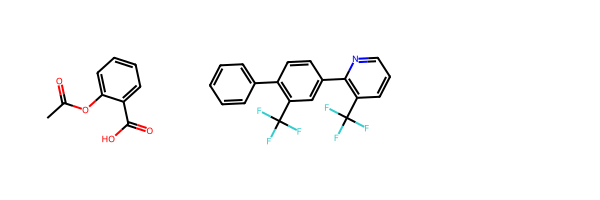

array([ True,  True,  True, ...,  True,  True,  True])